In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

In [4]:
# read CO2 concentration data
df=pd.read_csv('co2_mlo.tsv',delimiter='\t',header=None)
data=df.to_numpy()
time=data[:,2].astype(float)
co2=data[:,3].astype(float)
co2[co2<0]=np.nan
ind=(time>=1990)&(~np.isnan(co2))

In [5]:
# read CO2 emission data (RCP scenarios)
df_emis=pd.read_csv('CO2_emis_RCP.txt',delimiter='\t',skiprows=1)
data_emis=df_emis.to_numpy()
Year_emis=data_emis[:,0]
# unit: billion tonnes (10^12 kg)
CO2_emis_RCP=data_emis[:,1:]
df_emis

,Year,RCP26,RCP45,RCP60,RCP85
0,1990,22.70,22.70,22.70,22.70
1,1991,23.17,23.17,23.17,23.17
2,1992,22.44,22.44,22.44,22.44
3,1993,22.68,22.68,22.68,22.68
4,1994,22.84,22.84,22.84,22.84
...,...,...,...,...,...
106,2096,-1.26,15.28,52.32,105.01
107,2097,-1.33,15.24,51.91,105.13
108,2098,-1.40,15.21,51.49,105.25
109,2099,-1.47,15.18,51.08,105.37


In [6]:
m_air=5.148e18 # total mass of atmosphere, kg
CO2_emis_RCP_ppm=CO2_emis_RCP*1e12/m_air*(29/44)*1e6 # convert the unit: ppm/year
CO2_emis_RCP_ppm

array([[ 2.90624779e+00,  2.90624779e+00,  2.90624779e+00,
         2.90624779e+00],
       [ 2.96642121e+00,  2.96642121e+00,  2.96642121e+00,
         2.96642121e+00],
       [ 2.87296037e+00,  2.87296037e+00,  2.87296037e+00,
         2.87296037e+00],
       [ 2.90368722e+00,  2.90368722e+00,  2.90368722e+00,
         2.90368722e+00],
       [ 2.92417179e+00,  2.92417179e+00,  2.92417179e+00,
         2.92417179e+00],
       [ 2.98690577e+00,  2.98690577e+00,  2.98690577e+00,
         2.98690577e+00],
       [ 3.07908632e+00,  3.07908632e+00,  3.07908632e+00,
         3.07908632e+00],
       [ 3.09701031e+00,  3.09701031e+00,  3.09701031e+00,
         3.09701031e+00],
       [ 3.08676803e+00,  3.08676803e+00,  3.08676803e+00,
         3.08676803e+00],
       [ 3.12773716e+00,  3.12773716e+00,  3.12773716e+00,
         3.12773716e+00],
       [ 3.21607685e+00,  3.21607685e+00,  3.21607685e+00,
         3.21607685e+00],
       [ 3.24296285e+00,  3.24296285e+00,  3.24296285e+00,
      

In [7]:
# define the function for dX/dt
def fun_ODE(t,X, B, F, O):
    dX_dt=B*np.cos(2*np.pi*t)+F-O
    return dX_dt

In [8]:
ii=2 # RCP6.0
CO2_emis_ppm=CO2_emis_RCP_ppm[:,ii]
# construct interpolation
f_interp = interpolate.interp1d(Year_emis, CO2_emis_ppm)

In [9]:
# Numerical solution 
# setup model parameters
dt=0.01 # time step 0.01 year
# B=3*2*np.pi # respiration and photosynthesis cycles, ppmv/year
B=20
# we will dynamically update F and O values in the loop
# F=4 # fossil fuel emissions, ppmv/year
# O=2 # ocean uptake, ppmv/year

co2_sel=co2[ind]
t0=1990 # start time
t1=2099 # end time


X0=co2_sel[0] # initial CO2 concentration at t0

# generate time vector
T=np.arange(t0,t1,dt)

# number of time steps
N=np.size(T)


X=0*T # initialize X values with zeros
X[0]=X0 # initial value of X
for ii in np.arange(1,N, 1):
    # ii is for the time step n+1
    t=T[ii]-t0 # time of current step
    F=f_interp(T[ii]) # dynamically update emission of CO2
    O=0.475*F # fraction of CO2 emission absorbed by the ocean
     # X value in the previous time step
    Xn=X[ii-1]    
    dX_dt=fun_ODE(t,Xn, B, F, O)
    X[ii]=Xn+dX_dt*dt


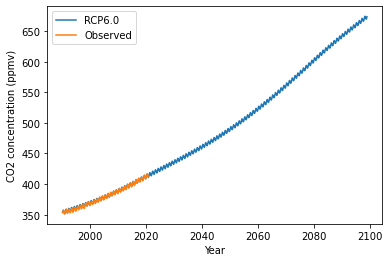

In [10]:

fig=plt.figure()
plt.plot(T,X,label='RCP6.0')
plt.plot(time[ind],co2[ind],label='Observed')
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppmv)')
plt.legend()

fn='fig_CO2_concentration_RCPs_HW'
plt.savefig('./fig/'+fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()